# Hop Teaming Analysis - Exploration of Data

## Team: The Hindenburgs

![The Hindenburgs](../img/the_hindenburgs_propaganda.png)

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

The four tables contained within 'hop_teaming_database.sqlite' are:

- hop_teaming
- nnpes
- nucc_taxonomy
- zip_cbsa
- tn_hospital_info
- facility_affiliation

## Exploratory Data Analysis

The starting point (below) is to find out all of the hospitals in the Nashville area, using:
- Selecting the entity type 2 (Hospitals, Urgent Care, Doctors Offices)
- Further, select classifications that end in Hospital from the taxonomy table
- TN as state from NNPES data
- CBSA 34980 for Nashville and surrounding area

**Important**:
- We tested the code with different res_ratio and found out that setting it anywhere from >= 0.1 to >= 0.75, the end result is the same
- By using **any** kind of cut on res_ratio, we lose lots of important referrals (to the point where it knocks down Vanderbilt from #1 on the list to about #6 or #7), so we decided against using res_ratio

That brings us to 141 total npis associated with hospitals

> NOTE: there are 32 entity_type_codes 2.0 in Nashville that have no primary taxonomy

> NOTE2: during first attempt we used `address_city_name = 'NASHVILLE'` however, that excludes hospitals located in Madison, Franklin or similar. that is the reason to use CBSA instead

In [126]:
query =f"""
WITH hospitals AS (
    SELECT DISTINCT npi
    FROM nnpes AS np
    INNER JOIN nucc_taxonomy AS nt
    ON np.primary_taxonomy = nt.code
    INNER JOIN zip_cbsa AS zc
    ON np.address_postal_code = zc.zip
    WHERE entity_type_code = 2.0
        AND address_state_name = 'TN'
        AND cbsa = 34980
        --AND res_ratio >= 0.5
        AND classification LIKE '%Hospital'
)
SELECT
    organization_name,
    SUM(patient_count) AS patient_total,
    SUM(transaction_count) AS transaction_total
FROM hop_teaming ht
INNER JOIN nnpes np
ON ht.to_npi = np.npi
WHERE to_npi IN hospitals
GROUP BY organization_name
"""

with sqlite3.connect('../data/hop_teaming_database.sqlite') as db: 
    hop_hospitals = pd.read_sql(query, db)

hop_hospitals

,organization_name,patient_total,transaction_total
0,BAPTIST WOMEN'S HEALTH CENTER LLC,12879,17519
1,"BEHAVIORAL HEALTHCARE CENTER AT COLUMBIA, LLC",1143,4033
2,CENTRAL TENNESSEE HOSPITAL CORPORATION,80134,127807
3,"CURAHEALTH NASHVILLE, LLC",820,1914
4,ENCOMPASS HEALTH REHABILITATION HOSPITAL OF FR...,4831,6482
5,"HCA HEALTH SERVICES OF TENNESSEE, INC.",673699,1117978
6,HENDERSONVILLE HOSPITAL CORPORATION,105268,163116
7,HTI MEMORIAL HOSPITAL CORPORATION,147367,251507
8,"MACON COUNTY GENERAL HOSPITAL, INC.",23563,41197
9,MAURY REGIONAL HOSPITAL,327428,585519


Using the list of hospital names from above, and the respective number of referrals, The Hindenburgs did some googling and discussion in order to establish which hospitals operate under the same medical network.

We were able to identify 6 major healthcare networks consisting of 21 hospitals from the list above:
- Vanderbilt
- HCA Healthcare
- Ascension
- Maury Regional Medical Group
- Williamson Medical Group
- High Point Health System

The remaining 13 hospitals were groupped as **other**.

## Major Hospital Networks

The first question posed to us was:
- First, build a profile of providers referring patients to the major hospitals in Nashville. Are certain specialties more likely to refer to a particular hospital over the others?

In [135]:
query = '''
WITH provider_referrals AS (
SELECT 
    n1.npi,
    t1.specialization
FROM nnpes n1
INNER JOIN nucc_taxonomy as t1
ON n1.primary_taxonomy = t1.code
WHERE n1.entity_type_code = 1
    AND t1.specialization <> 'None'
),
major_hospitals AS (
SELECT
    n2.npi,
    n2.organization_name,
    CASE
        WHEN organization_name = 'VANDERBILT UNIVERSITY MEDICAL CENTER'
            OR organization_name = 'SHELBYVILLE HOSPITAL COMPANY LLC'
            THEN 'Vanderbilt'
        WHEN organization_name = 'HCA HEALTH SERVICES OF TENNESSEE, INC.'
            OR organization_name = 'HTI MEMORIAL HOSPITAL CORPORATION'
            OR organization_name = 'HENDERSONVILLE HOSPITAL CORPORATION'
            OR organization_name = 'CENTRAL TENNESSEE HOSPITAL CORPORATION'
            OR organization_name = 'NORTHCREST MEDICAL CENTER'
            THEN 'HCA Healthcare'
        WHEN organization_name = 'SAINT THOMAS WEST HOSPITAL'
            OR organization_name = 'SAINT THOMAS RUTHERFORD HOSPITAL'
            OR organization_name = 'SAINT THOMAS RIVER PARK HOSPITAL, LLC'
            OR organization_name = 'SAINT THOMAS DEKALB HOSPITAL, LLC'
            OR organization_name = 'SAINT THOMAS STONES RIVER HOSPITAL, LLC'
            OR organization_name = 'RIVER PARK HOSPITAL LLC'
            THEN 'Ascension'
        WHEN organization_name = 'MAURY REGIONAL HOSPITAL'
            OR organization_name = 'MAURY REGIONAL HOSPITAL MARSHALL MEDICAL CENTER'
            THEN 'Maury Regional Medical Group'
        WHEN organization_name = 'WILLIAMSON COUNTY HOSPITAL DISTRICT'
            THEN 'Williamson Medical Group'
        WHEN organization_name = 'SUMNER REGIONAL MEDICAL CENTER LLC'
            OR organization_name = 'RIVERVIEW MEDICAL CENTER LLC'
            OR organization_name = 'SUMNER REGIONAL HEALTH SYSTEMS, INC'
            OR organization_name = 'TROUSDALE MEDICAL CENTER LLC'
            OR organization_name = 'SRHS HOLDINGS LLC'
            THEN 'High Point Health System'
        ELSE 'other'
    END AS parent_org    
FROM nnpes n2
INNER JOIN nucc_taxonomy as t2
ON n2.primary_taxonomy = t2.code
INNER JOIN zip_cbsa as zc
ON n2.address_postal_code = zc.zip
WHERE n2.address_state_name = 'TN'
    AND n2.entity_type_code = 2
    AND t2.classification LIKE '%Hospital'
    AND zc.cbsa = 34980
)
SELECT
    pr.npi AS from_npi,
    pr.specialization,
    mh.parent_org, 
    SUM(hop.transaction_count) AS total_transactions,
    SUM(hop.patient_count) AS total_patients
FROM hop_teaming AS hop
INNER JOIN provider_referrals pr
ON hop.from_npi = pr.npi
INNER JOIN major_hospitals mh
ON hop.to_npi = mh.npi 
GROUP BY pr.npi, pr.specialization, mh.parent_org
ORDER BY total_patients DESC;
'''

with sqlite3.connect('../data/hop_teaming_database.sqlite') as db: 
    providers_to_major_hospitals = pd.read_sql(query, db)

providers_to_major_hospitals.sample(5)

,from_npi,specialization,parent_org,total_transactions,total_patients
1842,1790869808,Nephrology,Vanderbilt,200,120
2435,1871677989,Hematology,Vanderbilt,78,77
670,1508854043,Neurology,HCA Healthcare,527,387
2599,1821357682,Family,Vanderbilt,109,68
3393,1376752980,Vascular Surgery,Vanderbilt,56,37


Next, we group by both the specialization (referring from) and the major hospital networks (referring to)

In [134]:
special_referrals = (
    providers_to_major_hospitals
        .drop(columns='from_npi')
        .groupby(['specialization','parent_org'])
        .sum(['total_transactions', 'total_patients'])
        .sort_values(['specialization', 'total_patients'], ascending=[True,False])
        .reset_index()
)

special_referrals.head(5)

,specialization,parent_org,total_transactions,total_patients
0,Acute Care,Vanderbilt,20031,13753
1,Acute Care,Ascension,7219,4934
2,Acute Care,HCA Healthcare,6480,4566
3,Acute Care,Maury Regional Medical Group,1169,763
4,Acute Care,High Point Health System,321,228


Discussing with the team it was decided that rather than go by sheer number of patients. We would like to know how often a specialization refers to a given parent organization (hospital network). So we decided to calculate the ratio of patients referred to a specific parent_org with respect to total referrals from that specialization.

We then used that information to extract the parent organization with the highest patient_ratio.

In [136]:
special_referrals['patients_ratio'] = (
    special_referrals['total_patients'] / special_referrals.groupby('specialization')['total_patients'].transform('sum')
)

(
special_referrals
    .loc[special_referrals
        .groupby(['specialization'])['patients_ratio']
        .transform(max) == special_referrals['patients_ratio']]
    .sort_values('patients_ratio', ascending = False)
)

,specialization,parent_org,total_transactions,total_patients,patients_ratio
310,"Psychiatric/Mental Health, Adult",Vanderbilt,53,47,1.000000
78,Clinical Genetics (M.D.),Vanderbilt,66,53,1.000000
251,Obstetrics,Maury Regional Medical Group,134,94,1.000000
82,Corneal and Contact Management,Vanderbilt,93,71,1.000000
83,Counseling,Ascension,91,55,1.000000
...,...,...,...,...,...
318,Pulmonary Disease,HCA Healthcare,28458,11540,0.332191
224,Nephrology,Vanderbilt,20436,10324,0.312564
114,Family,Vanderbilt,25172,17454,0.295961
138,Gastroenterology,Vanderbilt,11407,7869,0.293773


Visualizing the same information; Vanderbilt comes on top with 70 specializations (out of 110) referring most patients to them.

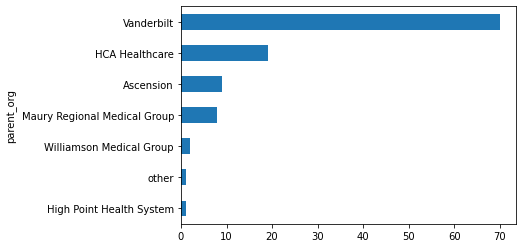

In [138]:
(
special_referrals
    .loc[special_referrals
        .groupby(['specialization'])['patients_ratio']
        .transform(max) == special_referrals['patients_ratio']]
    .sort_values('patients_ratio', ascending = False)
    .groupby('parent_org')['specialization']
    .count()
    .sort_values()
    .plot(kind='barh')
);

The second question posed to us was:

* Determine which professionals Vanderbilt Hospital should reach out to in the Nashville area to expand their own patient volume. 
    - First, research which professionals are sending significant numbers of patients only to competitor hospitals (such as TriStar Centennial Medical Center).
    - Next, consider the specialty of the provider. If Vanderbilt wants to increase volume from Orthopedic Surgeons or from Family Medicine doctors who should they reach out to in those areas?

We decided to find all npis that do not have a single referral to Vanderbilt.

> NOTE: most accidental referrals were eliminated by using transaction_count >= 50 and the average_day_wait < 50

In [152]:
# Essentially: first get the list of unique NPIs that have referred to Vanderbilt
# then exclude those npis

never_vandy_referrals = (
    providers_to_major_hospitals
        .loc[~providers_to_major_hospitals['from_npi']
            .isin(providers_to_major_hospitals.loc[providers_to_major_hospitals['parent_org'] == 'Vanderbilt']['from_npi'].unique())]
)

In [153]:
never_vandy_referrals['from_npi'].nunique()

1194

There are 1194 providers who don't refer to Vanderbilt. Below is also a breakdown by specialization.

In [154]:
(
    never_vandy_referrals
        .groupby('specialization')
        ['from_npi']
        .nunique()
        .sort_values(ascending=False)
)

specialization
Family                                                      270
Diagnostic Radiology                                        129
Cardiovascular Disease                                       64
Acute Care                                                   59
Pulmonary Disease                                            54
                                                           ... 
Oral and Maxillofacial Surgery                                1
Orthopedic                                                    1
Otology & Neurotology                                         1
Pediatric Cardiology                                          1
Neurology with Special Qualifications in Child Neurology      1
Name: from_npi, Length: 80, dtype: int64

In [155]:
(
    never_vandy_referrals
        .groupby('specialization')
        [['total_transactions', 'total_patients']]
        .sum()
        .sort_values(by='total_patients', ascending=False)
)

,total_transactions,total_patients
specialization,,
Diagnostic Radiology,241454,217066
Cardiovascular Disease,92913,62825
Family,56882,37053
Pulmonary Disease,49628,23992
Anatomic Pathology & Clinical Pathology,24944,23562
...,...,...
Orthopedic,60,47
Medical-Surgical,169,46
Oral and Maxillofacial Surgery,60,38


Alternatively, as suggested by Rohit, to try and find out any small number of referrals (proportionately, instead of just being 0), by pivotting the data. We set it up, but ultimately did not pursue this strategy. Could be potentially interesting for further analysis.

In [156]:
(
    providers_to_major_hospitals
        .groupby(['from_npi', 'specialization', 'parent_org'])
        ['total_patients']
        .sum()
        .reset_index()
        .pivot_table(values='total_patients', index=['from_npi','specialization'], columns='parent_org')
)

,parent_org,Ascension,HCA Healthcare,High Point Health System,Maury Regional Medical Group,Vanderbilt,Williamson Medical Group,other
from_npi,specialization,,,,,,,
1003019902,Neurology,NaN,NaN,NaN,NaN,271.0,NaN,NaN
1003031261,Hand Surgery,NaN,93.0,NaN,NaN,NaN,NaN,NaN
1003050972,Pulmonary Disease,NaN,NaN,NaN,NaN,190.0,NaN,NaN
1003098963,Psychiatric/Mental Health,NaN,NaN,NaN,NaN,28.0,NaN,NaN
1003112277,Family,70.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1992897326,Nephrology,NaN,NaN,NaN,NaN,439.0,29.0,NaN
1992902738,Acute Care,NaN,NaN,NaN,NaN,64.0,NaN,NaN
1992904049,Neurology,NaN,NaN,NaN,NaN,106.0,NaN,NaN


In [157]:
(
providers_to_major_hospitals
    .groupby(['specialization', 'parent_org'])
    ['total_patients']
    .sum()
    .reset_index()
    .pivot_table(values='total_patients', index='specialization', columns='parent_org')
)

parent_org,Ascension,HCA Healthcare,High Point Health System,Maury Regional Medical Group,Vanderbilt,Williamson Medical Group,other
specialization,,,,,,,
Acute Care,4934.0,4566.0,228.0,763.0,13753.0,40.0,53.0
Addiction Medicine,84.0,81.0,NaN,NaN,128.0,NaN,90.0
Addiction Psychiatry,NaN,NaN,NaN,NaN,89.0,NaN,NaN
Adolescent Medicine,48.0,30.0,NaN,224.0,68.0,NaN,NaN
Adult Congenital Heart Disease,NaN,NaN,NaN,NaN,70.0,NaN,NaN
...,...,...,...,...,...,...,...
Trauma Surgery,NaN,760.0,NaN,NaN,2254.0,NaN,NaN
Vascular & Interventional Radiology,1913.0,5153.0,NaN,NaN,1294.0,NaN,NaN
Vascular Neurology,489.0,NaN,NaN,NaN,411.0,NaN,NaN
